In [1]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt
from torch.autograd import Variable

from torch import nn, optim
from gpytorch.kernels import RBFKernel, GridInterpolationKernel
from gpytorch.means import ConstantMean
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.random_variables import GaussianRandomVariable

from torch.distributions.normal import Normal
from matplotlib import gridspec
import itertools

from dimension import Real,Integer, Categorical
from bayesian_optimization import BayesianOptimization

%matplotlib inline
%load_ext autoreload
%autoreload 2

torch.cuda.set_device(3)

In [2]:
# We use exact GP inference for regression
class GPRegressionModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(GPRegressionModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = ConstantMean(constant_bounds=[-3,3])
        # Put a grid interpolation kernel over the RBF kernel
        self.base_covar_module = RBFKernel(log_lengthscale_bounds=(-6, 6))
        self.covar_module = GridInterpolationKernel(self.base_covar_module, grid_size=400,
                                                            grid_bounds=[(-5, 15)])
        # Register kernel lengthscale as parameter
        self.register_parameter('log_outputscale', nn.Parameter(torch.Tensor([0])), bounds=(-6,6))
        
    def forward(self,x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        covar_x = covar_x.mul(self.log_outputscale.exp())
        return GaussianRandomVariable(mean_x, covar_x)


In [3]:
#minimize target function
def target(x):
    return -1*(3* torch.exp(-(x - 2)**2) + 2*torch.exp(-(x - 6)**2/8) + 1/ (x**2 + 1))


# Training data is 6 points in [-5,15] inclusive regularly spaced
train_x = Variable(torch.linspace(-5, 15, 6)).cuda()
# True function with Gaussian noise N(0,0.01)
# Maximize the negati-ve target function
train_y = Variable(-1* target(train_x)).cuda()

likelihood = GaussianLikelihood(log_noise_bounds=(-8, -7)).cuda()
model = GPRegressionModel(train_x.data, train_y.data, likelihood).cuda()

search_space = [Real(-5,15)]

In [4]:
#train before optimization
model.train()
likelihood.train()
optimizer = torch.optim.Adam([
        {'params': model.parameters()},  # Includes GaussianLikelihood parameters
    ], lr=0.1)
    # "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

training_iter = 20
for i in range(training_iter):
        # Zero gradients from previous iteration
    optimizer.zero_grad()
        # Output from model
    output = model(train_x)
        # Calc loss and backprop gradients
    loss = -mll(output, train_y)
    loss.backward()

    print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iter, loss.data[0]))
  
    optimizer.step()
'''
f, observed_ax = plt.subplots(1, 1, figsize=(4, 3))
observed_ax.plot(train_x.data.numpy(), train_y.data.numpy(), 'k*')
test_x = Variable(torch.linspace(-5, 15, 1000))
model.eval()
likelihood.eval()
with gpytorch.settings.max_cg_iterations(100):
    observed_pred = likelihood(model(test_x))
observed_ax.plot(test_x.data.numpy(),observed_pred.mean().data.numpy(), 'b')
'''

Iter 1/30 - Loss: 4.394
Iter 2/30 - Loss: 4.371
Iter 3/30 - Loss: 4.420
Iter 4/30 - Loss: 4.460
Iter 5/30 - Loss: 4.478
Iter 6/30 - Loss: 4.469
Iter 7/30 - Loss: 4.437
Iter 8/30 - Loss: 4.385
Iter 9/30 - Loss: 4.318
Iter 10/30 - Loss: 4.238
Iter 11/30 - Loss: 4.118
Iter 12/30 - Loss: 3.989
Iter 13/30 - Loss: 3.783
Iter 14/30 - Loss: 3.293
Iter 15/30 - Loss: 3.229
Iter 16/30 - Loss: 3.012
Iter 17/30 - Loss: 2.839
Iter 18/30 - Loss: 2.638
Iter 19/30 - Loss: 2.602
Iter 20/30 - Loss: 2.787
Iter 21/30 - Loss: 2.666
Iter 22/30 - Loss: 2.824
Iter 23/30 - Loss: 2.990
Iter 24/30 - Loss: 3.114
Iter 25/30 - Loss: 3.410
Iter 26/30 - Loss: 3.447
Iter 27/30 - Loss: 3.284
Iter 28/30 - Loss: 3.158
Iter 29/30 - Loss: 3.347
Iter 30/30 - Loss: 3.163


"\nf, observed_ax = plt.subplots(1, 1, figsize=(4, 3))\nobserved_ax.plot(train_x.data.numpy(), train_y.data.numpy(), 'k*')\ntest_x = Variable(torch.linspace(-5, 15, 1000))\nmodel.eval()\nlikelihood.eval()\nwith gpytorch.settings.max_cg_iterations(100):\n    observed_pred = likelihood(model(test_x))\nobserved_ax.plot(test_x.data.numpy(),observed_pred.mean().data.numpy(), 'b')\n"

after: self.model.train_inputs tensor([[ -5.0000],
        [ -1.0000],
        [  3.0000],
        [  7.0000],
        [ 11.0000],
        [ 15.0000],
        [  4.9499]], device='cuda:3')
Iter 1/10 - Loss: 3.203
Iter 2/10 - Loss: 2.827
Iter 3/10 - Loss: 2.679
Iter 4/10 - Loss: 3.050
Iter 5/10 - Loss: 2.924
Iter 6/10 - Loss: 2.972
Iter 7/10 - Loss: 3.146
Iter 8/10 - Loss: 3.111
Iter 9/10 - Loss: 3.357
Iter 10/10 - Loss: 3.292
after: self.model.train_inputs tensor([[ -5.0000],
        [ -1.0000],
        [  3.0000],
        [  7.0000],
        [ 11.0000],
        [ 15.0000],
        [  4.9499],
        [  3.6887]], device='cuda:3')
Iter 1/10 - Loss: 4.105
Iter 2/10 - Loss: 3.552
Iter 3/10 - Loss: 3.531
Iter 4/10 - Loss: 3.263
Iter 5/10 - Loss: 3.506
Iter 6/10 - Loss: 3.522
Iter 7/10 - Loss: 3.886
Iter 8/10 - Loss: 3.465
Iter 9/10 - Loss: 3.577
Iter 10/10 - Loss: 3.656
after: self.model.train_inputs tensor([[ -5.0000],
        [ -1.0000],
        [  3.0000],
        [  7.0000],
        [

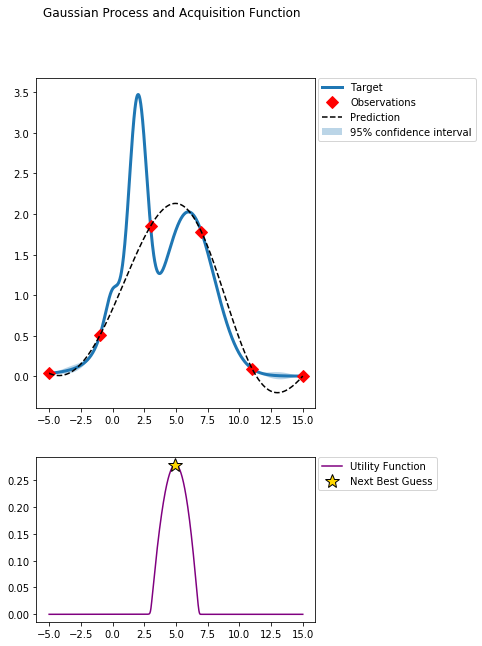

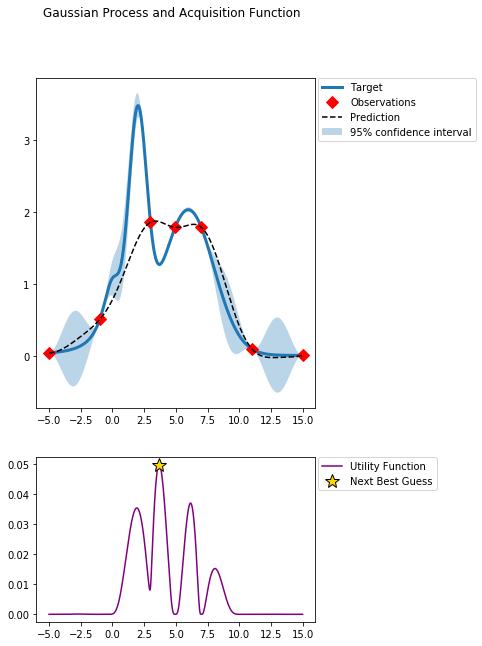

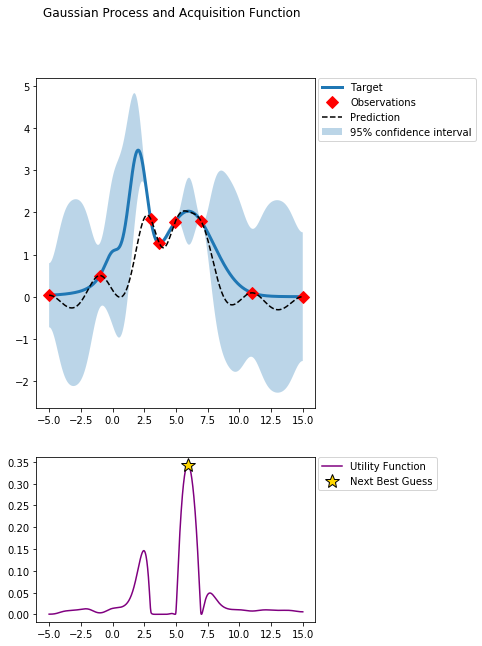

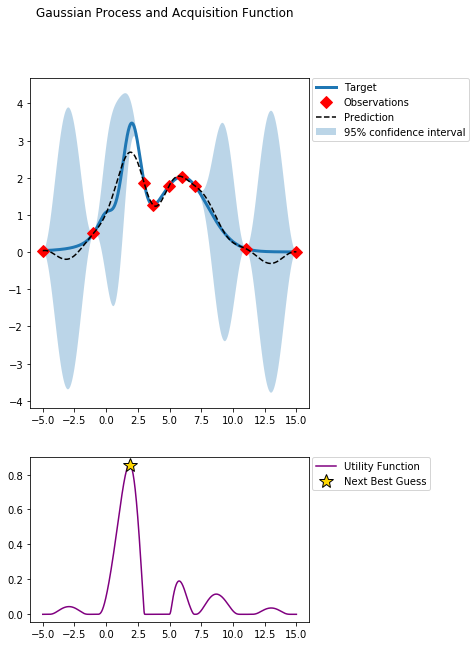

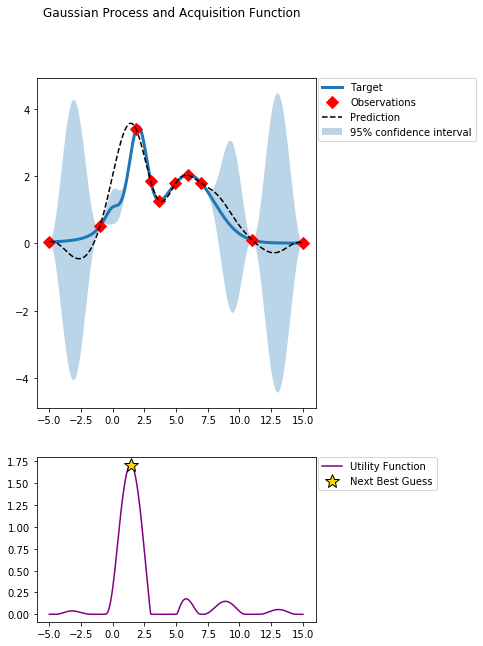

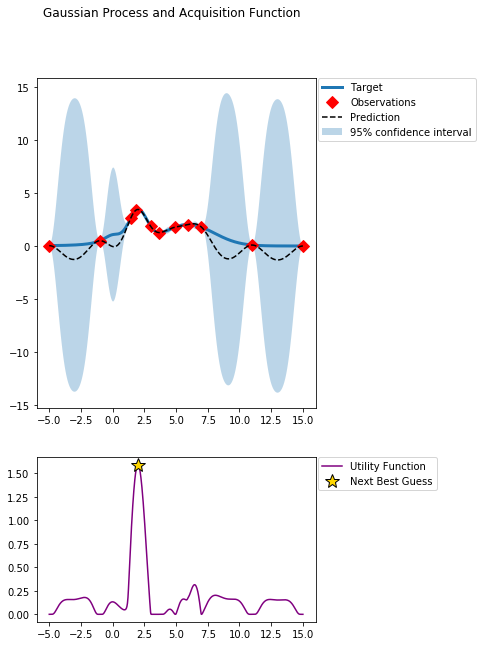

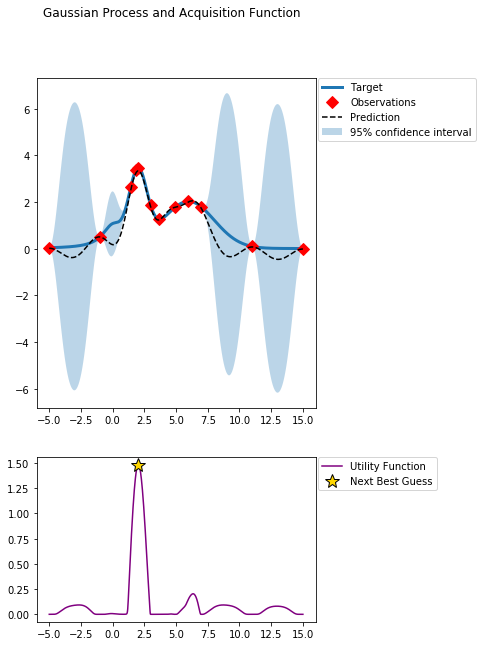

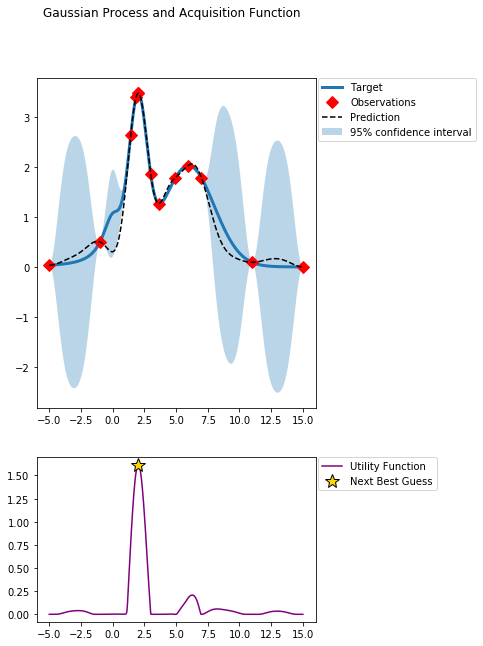

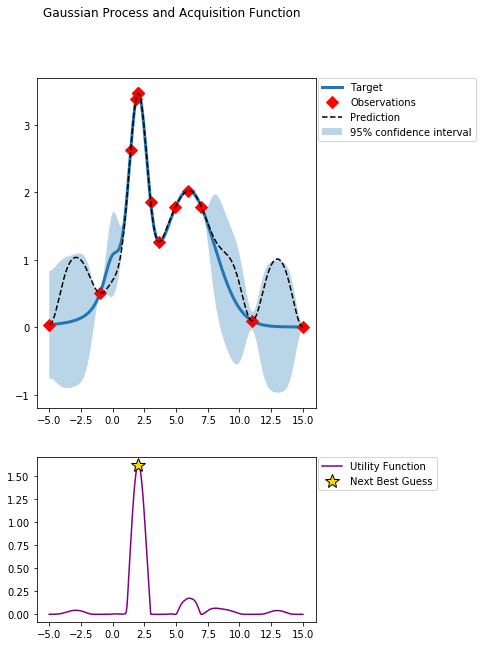

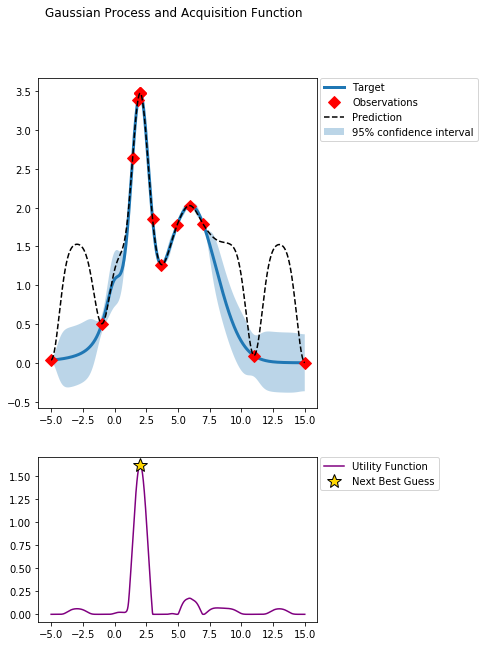

In [5]:
bo = BayesianOptimization(model, likelihood, target, search_space,"discrete_ei")

bo.optimal(10,plot=True)

In [6]:
bo.x_star

tensor([ 2.0270], device='cuda:3')

In [7]:
bo.y_star

tensor(-3.4716, device='cuda:3')